# The Battle of Neighborhoods

## Introduction

In the era of globalization, people moves a lot looking for better life and better work opportunities. Sometimes, this move becomes very hectic when it is to a completely unknown country or place. We people always have our own preference which might not match with other person. For example, my brother. He lives in India and works for a major US based IT firm. His company got a very good project to be executed for a client based out of Toronto, Canada. So my brother's company wants him to move to Toronto, Canada. 

This is the first time, my brother is moving outside of India and is completely confused in selecting the neighborhood for his staying. After doing almost a month's research, he reached out to me to help him out in selecting or recommending the neighborhood which will be best for him to stay.

When I started enquiring about his preferences, he came up with the following to be used as selection criteria:
 
 - Safe Neighborhood
 - Transportation - Metro Station, Bus Station
 - Breakfast places
 - Coffee Shops
 - Restaurants (Indian, Italian, Thai and American)
 - Shopping Center
 - Selected Bars - Sports Bar, Cocktail Bar, Pub
 - Outdoor Activity Center - Playground, Park
 
With these criteria provided by my brother, I would like to recommend to my brother which neighborhood of Toronto, Canada will be good for his living. The basis of this work will help the people like my brother to find their kind of neighborhood considering their preferences in mind. 



# Data Sources

### Neighborhood Data Source:
In Toronto, there are total 140 neighborhoods. To get the list of these neighborhood and their boundary information, I will be using the data from the below URL:
	http://data.torontopolice.on.ca/datasets/neighbourhood-crime-rates-boundary-file-
The data available in this page holds the below information:
	- Name of the neighborhood
	- Geometric information about the neighborhood (coordinates of the boundary)
	- Average crime rate for specific crimes till 2018.

I will use an Open Data Portal based API to access this data. The API RUL is : https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson  

From this dataset, I will use only the name of neighborhood, the boundary coordinates. Crime data will be skipped due to old information (data till 2018). This dataset has the boundary coordinates of each neighborhood, which is not suitable for getting the venues. As, the boundary coordinates are nothing but the coordinates of a polygon, that is why using the boundary coordinates, I have calculated the centroids of all the neighborhood and assigned them as centroid coordinates of each neighborhood. 

### Crime Data:
Basically Toronto is one of the safest place in the world, but in recent years, crime has started rising in some of the neighborhoods. We will use the crime incident data published by Toronto Police Department. This data set captured all the major crime reports since 2014 covering for all the 140 neighborhoods. The URL is: http://data.torontopolice.on.ca/datasets/mci-2014-to-2019. 

I have used the API exposed by Open Data Portal to access this data programmatically. The service URL is: https://opendata.arcgis.com/datasets/f4c2e5de021f4836a3caf77f8421f487_0.geojson. This dataset also contains the coordinates of all the places of the incidents. These coordinate information is not relevant here, so I will ignore those information.

In this dataset, the name of the neighborhood was having some additional information (HOOD ID, some number related to Toronto police data), which I had to strip it out so that both the neighborhood dataset and crime dataset
can have same neighborhood name.

As safety is his one of the priority, rather than considering all the 140 neighborhoods, I will take first 100 lowest crime based neighborhood.

From this dataset, I will use the below information:
 - Name of the neighborhood (after removing the Hood ID from the name)
 - Crime Incident
Then I will count the number of incidents for each neighborhood.

### Foursquare Venue data:
My brother has shared his preferred venues which he wants near to his future place of residence. It is quite possible that all venues might not be available at all neighborhood. To collect the list of preferred venues, I will be using the category hierarchy list to identify the categoryId of each preferred categories to filter out the non-preferred venues. The link for the Foursquare category list is below:
	https://developer.foursquare.com/docs/build-with-foursquare/categories/
	
Going through this page, at first I will collect all the nearest and closest categoryIds for all the preferred facilities my brother is looking for. Then I will use the Foursquare API for searching the venues by passing all these categoryIds. 

From this Foursquare dataset, we will collect all the preferred venues (name of the venue and venue category name) present for each 100 neighborhoods.

We will use clustering technique to group the neighborhoods based on their availability near to each neighborhood and then come up with the recommendations. 


### Collecting and building required Datasets

Import all required Python pachages

In [4]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
import folium
from IPython.display import HTML

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# Create an utility to determine the centroid (coordinates) of a neighborhood
# using the boundary coordinates
def getCentroidCoordinates(coordinates):
    det = 0.0
    tempDet = 0.0
    centroidX = 0.0
    centroidY = 0.0
    j = 0
    count = len(coordinates)
    for i in range(count):
        if i + 1 == count:
            j = 0
        else:
            j = i + 1
        tempDet = ((coordinates[i][1]*coordinates[j][0]) - (coordinates[j][1] * coordinates[i][0]))
        det += tempDet
        centroidX += (coordinates[i][1] + coordinates[j][1])*tempDet;
        centroidY += (coordinates[i][0] + coordinates[j][0])*tempDet;
        
    ## divide by the total mass of the polygon
    centroidX /= (3*det);
    centroidY /= (3*det);
    return centroidX, centroidY

#### Collecting the neighborhood data

I am using an Open Data Portal based API to access the neighborhood data. 

The API URL is : https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson

From this datasource, I am trying to fetch the below features:
  - Name of the Neighborhood
  - Boundary coordinates of respective neighborhoods

In [7]:
toronto_neighborhood_url = 'https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson'
neighborhood_results = requests.get(toronto_neighborhood_url).json()
neighborhoods = neighborhood_results["features"]

I will be using another Open Data Portal based API to access details of the major crime incidents. 

The data can be visualized in the Toronto Police Department website: http://data.torontopolice.on.ca/datasets/mci-2014-to-2019/data

The API URL is : https://opendata.arcgis.com/datasets/f4c2e5de021f4836a3caf77f8421f487_0.geojson

From this datasource, I am trying to fetch the below features:
  - Name of the Neighborhood
  - Major Crime Incident since 2014 till 2019
  


In [8]:
toronto_crime_url = 'https://opendata.arcgis.com/datasets/f4c2e5de021f4836a3caf77f8421f487_0.geojson'
crime_results = requests.get(toronto_crime_url).json()
crime_features = crime_results["features"]

Using this major crime incident dataset, we will create a new dataframe "crime_df". I will count all the major criminal incidents and the percentage of crime per neighborhood.

Then sort of "crime_df" dataframe by "Crime_Count" column.

In [13]:
crime_list = []
for feature in crime_features:
    name = feature["properties"]["Neighbourhood"]
    clean_name = name[0:name.find("(")].strip()
    #print("Neighborhood Name : " + name)
    crime_list.append([clean_name, 1])
    

toronto_crime_df = pd.DataFrame([item for item in crime_list])
toronto_crime_df.columns = ["Neighborhood", "Crime_Count"]
toronto_crime_df = crime_df.groupby(["Neighborhood"]).count()
toronto_crime_df.sort_values(by="Crime_Count", ascending = True, inplace=True)
toronto_crime_df = crime_df.reset_index()
toronto_crime_df['Percentage_Crime']= (crime_df['Crime_Count'])/crime_df['Crime_Count'].sum()
toronto_crime_df.head(10)

,index,Neighborhood,Crime_Count,Percentage_Crime
0,0,Lambton Baby Point,353,0.001710
1,1,Woodbine-Lumsden,377,0.001826
2,2,Maple Leaf,410,0.001986
3,3,Guildwood,411,0.001991
4,4,Yonge-St.Clair,412,0.001996
5,5,Markland Wood,413,0.002001
6,6,Old East York,479,0.002320
7,7,Casa Loma,480,0.002325
8,8,Forest Hill South,494,0.002393
9,9,Kingsway South,496,0.002403


So the safest neighborhood is Lambton Baby Point. The second safest neighborhood is Woodbine-Lumsden.

Let's see the neighborhood which are having higher criminal incidents.

In [15]:
toronto_crime_df.tail(10)

,index,Neighborhood,Crime_Count,Percentage_Crime
130,130,West Hill,3497,0.016940
131,131,Woburn,3798,0.018398
132,132,Kensington-Chinatown,3823,0.018519
133,133,Downsview-Roding-CFB,3974,0.019251
134,134,York University Heights,3989,0.019323
135,135,Moss Park,4786,0.023184
136,136,West Humber-Clairville,5702,0.027621
137,137,Church-Yonge Corridor,6232,0.030189
138,138,Bay Street Corridor,6817,0.033023
139,139,Waterfront Communities-The Island,7747,0.037528


So the highest crime rate is at Waterfront Communities-The Island. Compare to the number of incidents at Lambton Baby Point, the number of incidents at Waterfront communities is quite at higher side. 

So I would have to make sure not to recommend this neighborhood to my brother.

Let's visualize the Crime rate based division through Toronto's neighborhood map.

In [16]:
#url = 'https://opendata.arcgis.com/datasets'
#toronto_geo = f'{url}/af500b5abb7240399853b35a2362d0c0_0.geojson'
url = 'https://github.com/bitunsen/Coursera_Capstone/raw/master'
toronto_geo = f'{url}/toronto_neighborhood.geojson'
toronto_crime_map = folium.Map(location=[43.653522, -79.510540], zoom_start=10)

folium.Choropleth(
    geo_data=toronto_geo,
    name='choropleth',
    data=toronto_crime_df,
    columns=['Neighborhood', 'Percentage_Crime'],
    key_on='feature.properties.AREA_NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime Rate (%)'
).add_to(toronto_crime_map)

folium.LayerControl().add_to(toronto_crime_map)

toronto_crime_map

The Map can be viewed here as well: https://github.com/bitunsen/Coursera_Capstone/raw/master/Toronto_Crime_Data_Map.jpg

OR here below

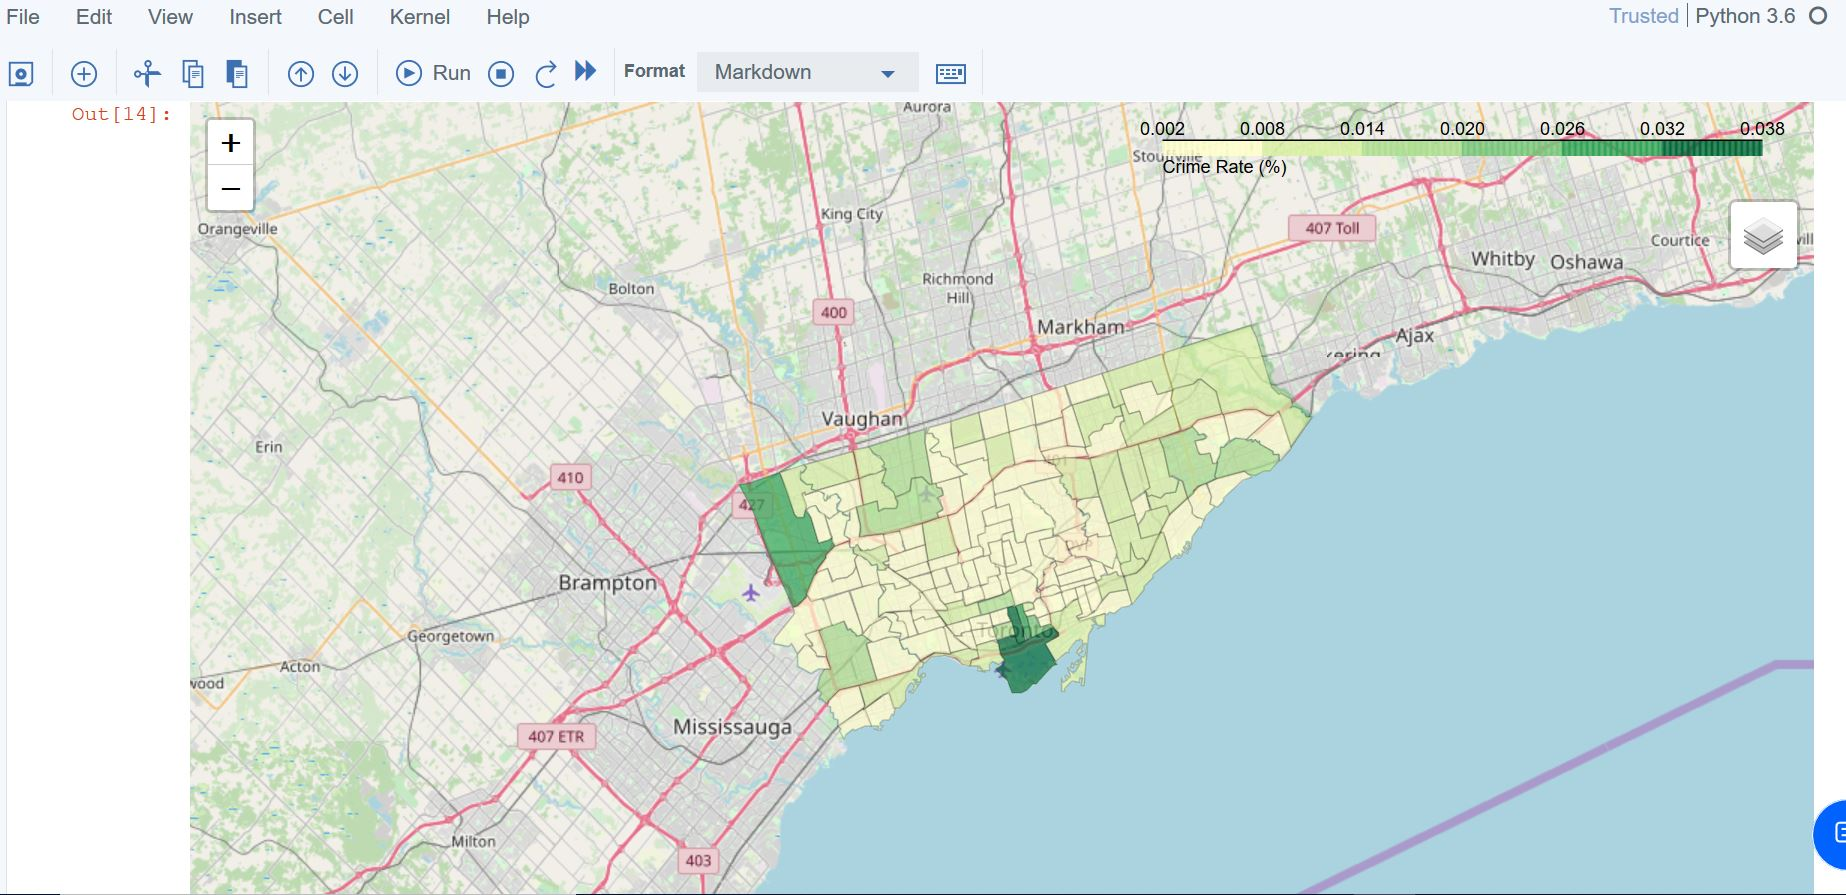



We will join both data sources by th eneighborhood name and then create a dataframe having below columns:
 - Neighborhood - Name of the neighborhood
 - Total number of Crime in a neighborhood
 - Percentage of Crime in a neighborhood
 - Centroid coordinates of each neighborhood (calculated using the boundary coordinates)

